In [42]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
plt.style.use('dark_background')
font = {'family': 'serif',
        'color':  'white',
        'weight': 'bold',
        'size': 16,
        }

In [43]:
df = pd.read_csv('Telco-Customer-Churn.csv')

In [44]:
df[df['TotalCharges'].str.replace('.','').str.isdigit()==False]['TotalCharges'].unique()
df['TotalCharges'] = df['TotalCharges'].replace(' ',np.nan)
df = df.dropna()
df['TotalCharges'] = df['TotalCharges'].astype('float')
df = df.drop(columns='customerID')
df['Churn'] = [1 if x=='Yes' else 0 for x in df['Churn']]
df['SeniorCitizen'] = df['SeniorCitizen'].replace({'Yes':1,'No':0})

C:\Users\asus\AppData\Local\Temp\ipykernel_2412\3193955692.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[df['TotalCharges'].str.replace('.','').str.isdigit()==False]['TotalCharges'].unique()


In [45]:
# change MonthlyCharges to categorical column
def monthlycharges_split(df) :   
    if df['MonthlyCharges'] <= 30 :
        return '0-30'
    elif (df['MonthlyCharges'] > 30) & (df['MonthlyCharges'] <= 70 ):
        return '30-70'
    elif (df['MonthlyCharges'] > 70) & (df['MonthlyCharges'] <= 99 ):
        return '70-99'
    elif df['MonthlyCharges'] > 99 :
        return '99plus'
df['monthlycharges_group'] = df.apply(lambda df:monthlycharges_split(df), axis = 1)

# change TotalCharges to categorical column
def totalcharges_split(df) :   
    if df['TotalCharges'] <= 2000 :
        return '0-2k'
    elif (df['TotalCharges'] > 2000) & (df['TotalCharges'] <= 4000 ):
        return '2k-4k'
    elif (df['TotalCharges'] > 4000) & (df['TotalCharges'] <= 6000) :
        return '4k-6k'
    elif df['TotalCharges'] > 6000 :
        return '6kplus'
df['totalcharges_group'] = df.apply(lambda df:totalcharges_split(df), axis = 1)

# change Tenure to categorical column
def tenure_split(df) :   
    if df['tenure'] <= 20 :
        return '0-20'
    elif (df['tenure'] > 20) & (df['tenure'] <= 40 ):
        return '20-40'
    elif (df['tenure'] > 40) & (df['tenure'] <= 60) :
        return '40-60'
    elif df['tenure'] > 60 :
        return '60plus'
df['tenure_group'] = df.apply(lambda df:tenure_split(df), axis = 1)

In [46]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# customer id col
Id_col     = ['customerID']
# Target columns
target_col = ['Churn']
#categorical columns
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = df.nunique()[df.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    df[i] = le.fit_transform(df[i])
    
#Duplicating columns for multi value columns
df = pd.get_dummies(data = df, columns = multi_cols)

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df1 = df.drop(columns = num_cols, axis = 1)
df1 = df1.merge(scaled, left_index=True, right_index=True, how = "left")


In [47]:
df1.describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,...,totalcharges_group_2k-4k,totalcharges_group_4k-6k,totalcharges_group_6kplus,tenure_group_0-20,tenure_group_20-40,tenure_group_40-60,tenure_group_60plus,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.00000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7021.000000,7021.000000,7021.000000
mean,0.504693,0.162400,0.482509,0.298493,0.903299,0.592719,0.265785,0.481371,0.096701,0.421928,...,0.171786,0.13595,0.098407,0.407708,0.200228,0.191980,0.200085,0.000538,-0.000271,0.000450
std,0.500014,0.368844,0.499729,0.457629,0.295571,0.491363,0.441782,0.499688,0.295571,0.493902,...,0.377221,0.34276,0.297886,0.491443,0.400199,0.393885,0.400092,1.000141,0.999997,1.000279
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.280248,-1.547283,-0.999069
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.954296,-0.970561,-0.830227
50%,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.139417,0.184544,-0.390473
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.919926,0.832733,0.667141
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.612573,1.793381,2.824261


In [48]:
# there are a lot of repeated features (no internet service), so drop them
df1 = df1.drop(columns=['OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 
                        'DeviceProtection_No internet service', 'TechSupport_No internet service', 
                        'StreamingTV_No internet service', 'StreamingMovies_No internet service'], axis=1)

In [49]:
# df1 = df1.drop(columns=['tenure','MonthlyCharges','TotalCharges'])

In [50]:
df1.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,...,totalcharges_group_2k-4k,totalcharges_group_4k-6k,totalcharges_group_6kplus,tenure_group_0-20,tenure_group_20-40,tenure_group_40-60,tenure_group_60plus,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,-1.280248,-1.161694,-0.994194
1,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0.064303,-0.260878,-0.173740
2,1,0,0,0,1,1,1,1,0,0,...,0,0,0,1,0,0,0,-1.239504,-0.363923,-0.959649
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0.512486,-0.747850,-0.195248
4,0,0,0,0,1,1,1,1,0,0,...,0,0,0,1,0,0,0,-1.239504,0.196178,-0.940457


In [51]:
df1 = df1.dropna()

In [52]:
y = df1['Churn'].values
X = df1.drop(columns = ['Churn'])

# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [ ]:
def evaluating(model,X_test,y_test):
    y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)*100
    print ('Accuracy:',acc,'%')
    auc = roc_auc_score(y_test, y_pred)
    print()
    print('Classification Report:')
    cr = classification_report(y_test, y_pred)
    print(cr)
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['No','Yes']
    group_names = ['True No','False Yes', 'False No','True Yes'] #configuration of a confusin matrix
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)] #converting confusion matrix value to percentage in 2 decimal places.

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    print()
    print('Confusion matrix')
    conf_m = sns.heatmap(cf_matrix, annot = labels, cmap = 'PiYG',fmt = '',
                xticklabels = categories, yticklabels = categories)
    plt.show()
    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    print()
    print('ROC Curve:')
    #create ROC curve
    auc_curve = plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    return acc, conf_m, auc_curve

Accuracy: 81.30042714760323 %

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1554
           1       0.68      0.54      0.60       553

    accuracy                           0.81      2107
   macro avg       0.76      0.73      0.74      2107
weighted avg       0.80      0.81      0.81      2107


Confusion matrix


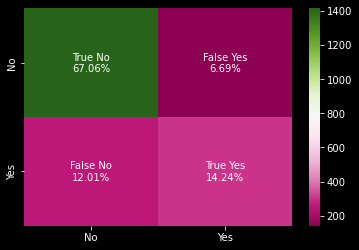


ROC Curve:


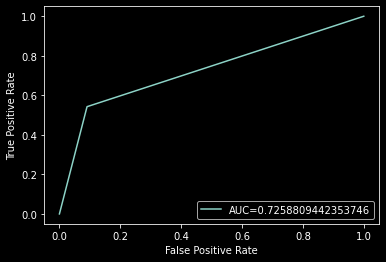

In [55]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model = model.fit(X_train, y_train)
a = evaluating(model,X_test,y_test)

Accuracy: 79.02230659705742 %

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1554
           1       0.61      0.55      0.58       553

    accuracy                           0.79      2107
   macro avg       0.73      0.71      0.72      2107
weighted avg       0.78      0.79      0.79      2107


Confusion matrix


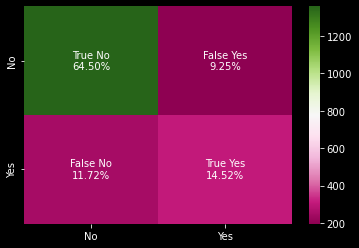


ROC Curve:


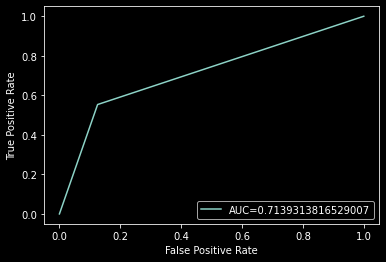

In [56]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(metric='manhattan', n_neighbors=50, leaf_size=1)
model = model.fit(X_train, y_train)
a = evaluating(model,X_test,y_test)

In [57]:
#List Hyperparameters that we want to tune.
# import time
# t1 = time.time()
# leaf_size = list(range(1,50))
# n_neighbors = list(range(1,30))
# p=[1,2]
# #Convert to dictionary
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
# #Create new KNN object
# knn_2 = KNeighborsClassifier()
# #Use GridSearch
# print('quick till here')
# clf = GridSearchCV(knn_2, hyperparameters, cv=10, n_jobs=2)
# t2 = time.time()
# #Fit the model
# best_model = clf.fit(X_train,y_train)
# #Print The value of best Hyperparameters
# print('Time taken:',t2-t1)
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Accuracy: 75.41528239202658 %

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1554
           1       0.52      0.74      0.61       553

    accuracy                           0.75      2107
   macro avg       0.71      0.75      0.72      2107
weighted avg       0.79      0.75      0.77      2107


Confusion matrix


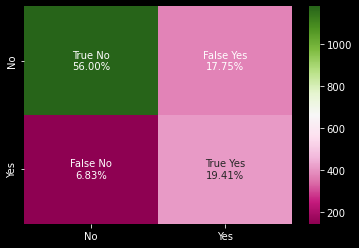


ROC Curve:


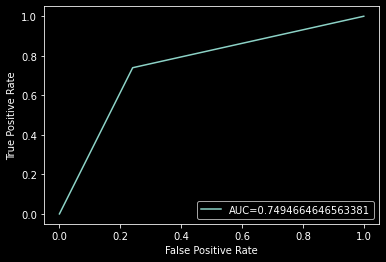

In [58]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model = model.fit(X_train, y_train)
a = evaluating(model,X_test,y_test)

In [59]:
model.classes_

array([0, 1], dtype=int64)

In [60]:
model.class_log_prior_

array([-0.31087669, -1.31977368])

Accuracy: 72.56763170384433 %

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1554
           1       0.48      0.50      0.49       553

    accuracy                           0.73      2107
   macro avg       0.65      0.65      0.65      2107
weighted avg       0.73      0.73      0.73      2107


Confusion matrix


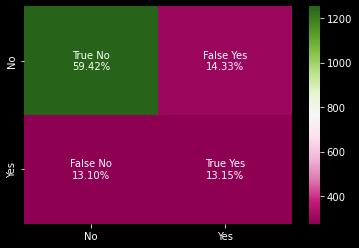


ROC Curve:


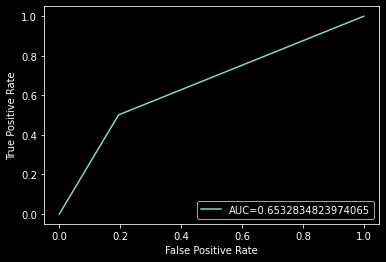

In [61]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion="log_loss")
result = model.fit(X_train, y_train)
a = evaluating(model,X_test,y_test)

Accuracy: 78.69008068343616 %

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1554
           1       0.62      0.47      0.54       553

    accuracy                           0.79      2107
   macro avg       0.73      0.68      0.70      2107
weighted avg       0.77      0.79      0.78      2107


Confusion matrix


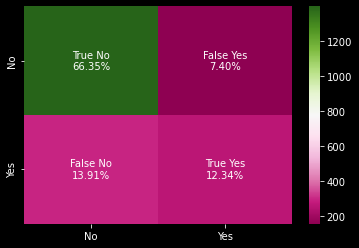


ROC Curve:


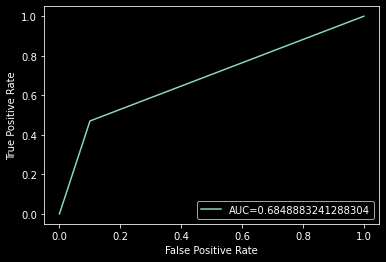

In [62]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
result = model.fit(X_train, y_train)
a = evaluating(model,X_test,y_test)

Accuracy: 81.015662078785 %

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1554
           1       0.68      0.52      0.59       553

    accuracy                           0.81      2107
   macro avg       0.76      0.72      0.73      2107
weighted avg       0.80      0.81      0.80      2107


Confusion matrix


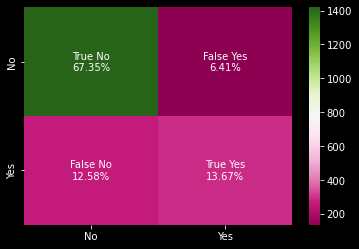


ROC Curve:


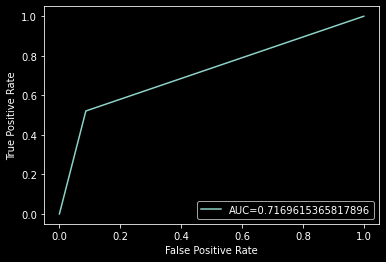

Accuracy: 81.015662078785 %

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1554
           1       0.69      0.51      0.59       553

    accuracy                           0.81      2107
   macro avg       0.76      0.71      0.73      2107
weighted avg       0.80      0.81      0.80      2107


Confusion matrix


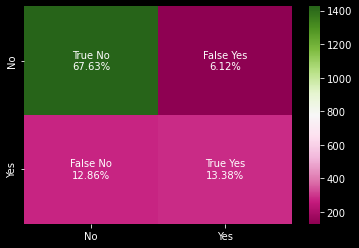


ROC Curve:


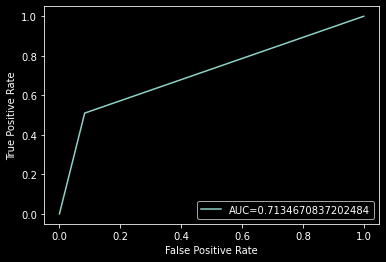

In [66]:
from sklearn.svm import LinearSVC, SVC
model = LinearSVC()
result = model.fit(X_train, y_train)
a = evaluating(model,X_test,y_test)

model = SVC()
result = model.fit(X_train, y_train)
a = evaluating(model,X_test,y_test)

In [69]:
# # Plot data points and color using their class
# color = ['black' if c == 0 else 'lightgrey' for c in y]
# plt.scatter(X[:,0], X[:,1], c=color)

# # Create the hyperplane
# w = svc.coef_[0]
# a = -w[0] / w[1]
# xx = np.linspace(-2.5, 2.5)
# yy = a * xx - (svc.intercept_[0]) / w[1]

# # Plot the hyperplane
# plt.plot(xx, yy)
# plt.axis("off"), plt.show();

Accuracy: 80.49359278595159 %

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1554
           1       0.65      0.55      0.60       553

    accuracy                           0.80      2107
   macro avg       0.75      0.72      0.73      2107
weighted avg       0.80      0.80      0.80      2107


Confusion matrix


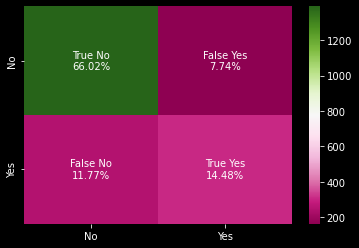


ROC Curve:


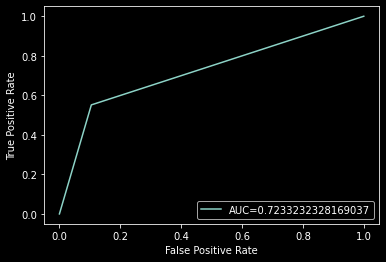

In [64]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
# n_estimators = 50 (default value) 
# base_estimator = DecisionTreeClassifier (default value)
model.fit(X_train,y_train)
a = evaluating(model,X_test,y_test)

In [65]:
AdaBoostClassifier?

Init signature:
AdaBoostClassifier(
    base_estimator=None,
    *,
    n_estimators=50,
    learning_rate=1.0,
    algorithm='SAMME.R',
    random_state=None,
)
Docstring:     
An AdaBoost classifier.

An AdaBoost [1] classifier is a meta-estimator that begins by fitting a
classifier on the original dataset and then fits additional copies of the
classifier on the same dataset but where the weights of incorrectly
classified instances are adjusted such that subsequent classifiers focus
more on difficult cases.

This class implements the algorithm known as AdaBoost-SAMME [2].

Read more in the :ref:`User Guide <adaboost>`.

.. versionadded:: 0.14

Parameters
----------
base_estimator : object, default=None
    The base estimator from which the boosted ensemble is built.
    Support for sample weighting is required, as well as proper
    ``classes_`` and ``n_classes_`` attributes. If ``None``, then
    the base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`
    initialized wit